In [1]:
import os
import time
import random
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.optim as optim
from einops import rearrange
import torch.nn.functional as F
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from timm.models.vision_transformer import Block


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from CNNUtils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("SSFTTnet")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 30, 15, 15)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 30, 15, 15)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 30, 15, 15)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 30, 15, 15])
torch.Size([42551, 30, 15, 15])
torch.Size([900, 30, 15, 15])


## Model

In [11]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  32

    pos = pos.reshape(-1)  # (M, )  169
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    center_index = (grid_size-1) // 2

    row_index = np.zeros([grid_size, grid_size], dtype=np.float32)
    for i in range(grid_size):
        row_index[i, :] = abs(i - center_index)

    column_index = []
    for i in range(grid_size):
        temp_index = []
        for j in range(grid_size):
            temp_index.append(max(abs(i - center_index), abs(j - center_index)))
        column_index.append(temp_index)
    column_index = np.asarray(column_index, dtype=np.float32)
    
    grid = np.stack([column_index, row_index], axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [12]:
class SE(nn.Module):
    def __init__(self, in_chnls, ratio):
        super(SE, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))
        self.compress = nn.Conv2d(in_chnls, in_chnls//ratio, 1, 1, 0)
        self.excitation = nn.Conv2d(in_chnls//ratio, in_chnls, 1, 1, 0)

    def forward(self, x):
        out = self.squeeze(x)
        out = self.compress(out)
        out = F.relu(out)
        out = self.excitation(out)
        out = torch.sigmoid(out) * x + x
        return out 


class SQSFormer(nn.Module):
    def __init__(self, in_chans=30, grid_size=15, embed_dim=64, depth=3, num_classes=9):
        super(SQSFormer, self).__init__()
        self.grid_size = grid_size
        self.conv2d = nn.Sequential(nn.Conv2d(in_chans, embed_dim, 3, 1, 1), nn.BatchNorm2d(embed_dim), nn.ReLU())
        self.senet = SE(embed_dim, 4)
        
        self.block_0 = Block(embed_dim, num_heads=4, qkv_bias=True, drop=0.1, attn_drop=0.1)
        self.block_1 = Block(embed_dim, num_heads=4, qkv_bias=True, drop=0.1, attn_drop=0.1)
        self.block_2 = Block(embed_dim, num_heads=4, qkv_bias=True, drop=0.1, attn_drop=0.1)

        self.drop = nn.Dropout(0.1)

        self.pos_embed = nn.Parameter(torch.zeros(1, grid_size**2, embed_dim), requires_grad=False) 
        pos_embed = get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.fusion_matrix = nn.Parameter(torch.randn(1, 1, depth))
        self.cls_head = nn.Sequential(nn.Linear(embed_dim, 32), nn.BatchNorm1d(32), nn.Dropout(0.1), nn.ReLU(), nn.Linear(32, num_classes))

    def random_rotation(self, x):
        # x: (B, 30, 15, 15)
        b = x.size(0)
        collect = []
        for i in range(b):
            random_integer = torch.randint(0, 4, (1,)).item()
            rotated_img = torch.rot90(x[i], random_integer, (1, 2))
            collect.append(rotated_img)
        x = torch.stack(collect)
        return x

    def forward(self, x):
        # x: (B, 30, 15, 15)
        if self.training:
            x = self.random_rotation(x)
        x = self.conv2d(x)  # (B, 64, 15, 15)
        x = self.senet(x)  # (B, 64, 15, 15)
        x = rearrange(x,'b c h w -> b (h w) c')  # (B, 225, 64)
        
        x += self.pos_embed  # (B, 225, 64)
        center_index = (self.grid_size ** 2 - 1) // 2  # 112
        
        x = self.block_0(x)  # (B, 225, 64)
        x0 = x[:, center_index, :]  # (B, 64)
        
        x = self.block_1(x)
        x1 = x[:, center_index, :]  # (B, 64)
        
        x = self.block_2(x)
        x2 = x[:, center_index, :]  # (B, 64)
        
        x = torch.stack([x0, x1, x2], dim=1)  # (B, 3, 64)
        x = torch.matmul(self.fusion_matrix, x).squeeze(dim=1)  # (B, 64)

        x = self.cls_head(x)
        return x

In [13]:
model = SQSFormer(num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-06)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [14]:
print('start training')
acc_list = [0.00]
path = './model/SQSFormer.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to SQSFormer.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 1.9096 - train_acc: 32.4444 - valid_loss: 1.6776 - valid_acc: 57.5556
val_acc improved from 0.0000 to 57.5556, saving model to SQSFormer.pt
Epoch: 002 - train_loss: 1.4917 - train_acc: 66.6667 - valid_loss: 1.2711 - valid_acc: 69.3333
val_acc improved from 57.5556 to 69.3333, saving model to SQSFormer.pt
Epoch: 003 - train_loss: 1.2802 - train_acc: 69.3333 - valid_loss: 1.0396 - valid_acc: 73.6667
val_acc improved from 69.3333 to 73.6667, saving model to SQSFormer.pt
Epoch: 004 - train_loss: 1.1169 - train_acc: 80.0000 - valid_loss: 0.9596 - valid_acc: 81.8889
val_acc improved from 73.6667 to 81.8889, saving model to SQSFormer.pt
Epoch: 005 - train_loss: 1.0265 - train_acc: 80.8889 - valid_loss: 0.8902 - valid_acc: 84.8889
val_acc improved from 81.8889 to 84.8889, saving model to SQSFormer.pt
Epoch: 006 - train_loss: 0.9490 - train_acc: 86.2222 - valid_loss: 0.8379 - valid_acc: 87.1111
val_acc improved from 84.8889 to 87.1111, saving model to SQS

In [15]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [16]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 96.30, AA: 95.27, Kappa: 0.9509
*******************************************************************
Recal: [ 97.46  97.89  78.01  96.58 100.    99.42 100.    88.43  99.67]
*******************************************************************
Parameter:
dataset: Pavia
seed: 42
batch_size: 30
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 25
*******************************************************************


In [ ]:
average_accuracy = str(list(AA_test))
file_name = "./CR/sqsformer_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [17]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [18]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [19]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 30, 15, 15])
torch.Size([164624, 30, 15, 15])


In [20]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

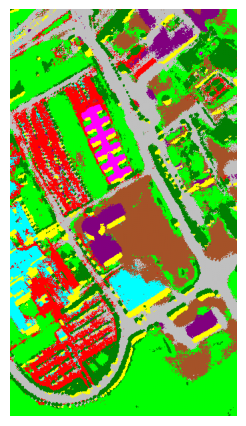

In [21]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pu_sqsformer.pdf')